In [93]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd=tfp.distributions
tfb=tfp.bijectors
print("TF version:", tf.__version__)
print("TFP version:", tfp.__version__)

TF version: 2.1.0
TFP version: 0.9.0


# Variational autoencoders

# Autoencoder

Remember that a $\textbf{classic autoencoder}$ can be understood as a compression and decompression algorithm similar to the VAE. An autoencoder is not a probabilistic model, so it does not model the distribution reflected by the data, but it is a first step to understand the $\textbf{variational autoencoder}$.

In [ ]:
#note that we are not using TensorFlow Probability
#also note how the units are reduced to a bottleneck (compression)
#then start to increase (decompression) this is the basic behavior of the autoencoder

autoencoder=Sequential([
    #compression
    Flatten(input_shape=(28,28)),
    Dense(256,activation='sigmoid'),
    Dense(64,activation='sigmoid'),
    #bottleneck
    Dense(2,activation='sigmoid'),
    #decompression
    Dense(64,activation='sigmoid'),
    Dense(256,activation='sigmoid'),
    Dense(784,activation='sigmoid'),
    #output in the same form as the input
    Reshape((28,28))
])

#when training an autoencoder we pass the inputs equal to the outputs:


opt=tf.keras.optimizersRMSprop(learning_rate=0.0005)
autoencoder.compile(loss='mse',optimizer=opt)

#note that we don't pass autoencoder.fit(x_train, y_train, epochs=20) as we usually do when training another network
autoencoder.fit(x_train,x_train,epochs=20)

#This makes it an unsupervised model since it does not use labels; instead, it is trained to try to 
#reconstruct the data it was trained on. It does this by forcing the network to learn a compressed 
#representation of each data point that captures the main features of the data if it can reconstruct 
#the data through an approximation from the compressed version.
#In practice, the layers separated by the bottleneck are treated separately, 
#understood as the encoder and the decoder respectively.

## Encoder
It is responsible for compressing and extracting the features of the data.

In [ ]:
#It can be defined as a sub-model:
#It receives a batch of data and encodes it.
encoder=Sequential([
    Flatten(input_shape=(28,28)),
    Dense(256,activation='sigmoid'),
    Dense(64,activation='sigmoid'),
    Dense(2)
])


# Decoder

It is responsible for reconstructing an approximation of the data from the compression of the encoder.

In [ ]:
# It can also be defined as a sub-model
# It receives a batch of data and approximates (decodes) them.

decoder=Sequential([
    Dense(64,activation='sigmoid',input_shape=(2,)),
    Dense(256,activation='sigmoid'),
    Dense(784,activation='sigmoid'),
   #output in the same form as the input
    Reshape((28,28))
])


# Autoencoder

Thus, the Autoencoder can be seen as a model based on these two.

In [ ]:
autoencoder=Model(inputs=encoder.input,outputs=decoder(encoder.output))

autoencoder.compile(loss='mse',optimizer='sgd')
autoencoder.fit(x_train,x_train,epochs=20)

#We can test on a data x_test with shape (1, 28, 28)
#where the first dimension 1 is added to simulate the batch


x_reconstruction=autoencoder(x_test) #output shape (1,28,28)

#The advantage of treating the encoder and decoder as separate models is that we now have
#access to see how it encodes and decodes.

#Let's see the encoding it does for x_test:


x_encoded=encoder(x_test) #Returns data of shape (1,2)


#We can also see its decoding if we generate a random data


z_random=tf.random.normal([1,2]
z_decoded=decoder(z_random) # Returns data of shape (1,28,28)
#i.e., it generates something trying to interpret the random input with the features it learned.

#Note that this autoencoder is not generative since it is not able to learn the distribution of the data,
#meaning the decoding of z_random might not even resemble the training data.

<a class="anchor" id="tutorial1"></a>
## Encoders and decoders

In [62]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [9]:
# Load Fashion MNIST

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.
class_names = np.array(['T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress',
                        'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag','Ankle boot'])

4423680/4422102 [==============================] - 0s 0us/step


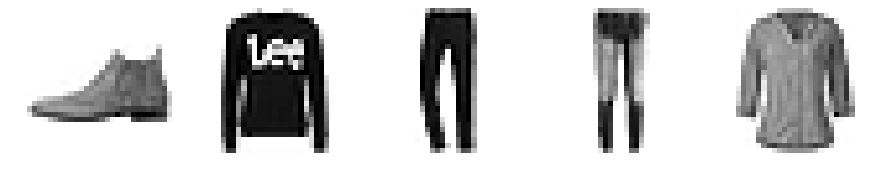

In [10]:
# Display a few examples

n_examples = 1000
example_images = x_test[0:n_examples]
example_labels = y_test[0:n_examples]

f, axs = plt.subplots(1, 5, figsize=(15, 4))
for j in range(len(axs)):
    axs[j].imshow(example_images[j], cmap='binary')
    axs[j].axis('off')

In [12]:
# Define the encoder

encoded_dim=2

encoder=Sequential([
    Flatten(input_shape=(28,28)),
    Dense(256,activation='sigmoid'),
    Dense(64,activation='sigmoid'),
    Dense(encoded_dim)
])


In [13]:
# Encode examples before training

pretrain_example_encodings=encoder(example_images).numpy()

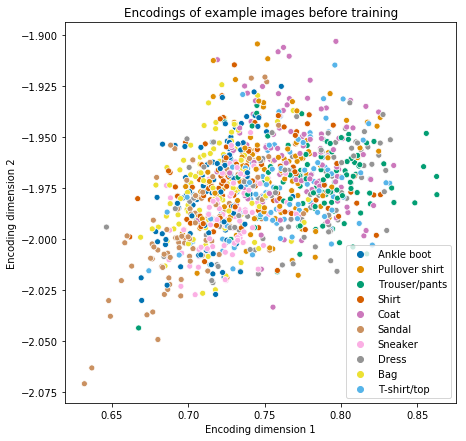

In [14]:
# Plot encoded examples before training 

f, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(pretrain_example_encodings[:, 0],
                pretrain_example_encodings[:, 1],
                hue=class_names[example_labels], ax=ax,
                palette=sns.color_palette("colorblind", 10));
ax.set_xlabel('Encoding dimension 1'); ax.set_ylabel('Encoding dimension 2')
ax.set_title('Encodings of example images before training');

In [15]:
# Define the decoder
decoder=Sequential([
    Dense(64,activation='sigmoid',input_shape=(encoded_dim,)),
    Dense(256,activation='sigmoid'),
    Dense(28*28,activation='sigmoid'),
    Reshape((28,28))
])


In [18]:
# Compile and fit the model
autoencoder=Model(inputs=encoder.inputs,outputs=decoder(encoder.outputs))


# Specify loss - input and output is in [0., 1.], so we can use a binary cross-entropy loss
autoencoder.compile(loss='binary_crossentropy')

# Fit model - highlight that labels and input are the same

autoencoder.fit(x=x_train,y=x_train,epochs=10,batch_size=32)



Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 77s 1ms/sample - loss: 0.3796
Epoch 2/10
60000/60000 [==============================] - 75s 1ms/sample - loss: 0.3410
Epoch 3/10
60000/60000 [==============================] - 75s 1ms/sample - loss: 0.3336
Epoch 4/10
60000/60000 [==============================] - 74s 1ms/sample - loss: 0.3300
Epoch 5/10
60000/60000 [==============================] - 74s 1ms/sample - loss: 0.3274
Epoch 6/10
60000/60000 [==============================] - 75s 1ms/sample - loss: 0.3252
Epoch 7/10
60000/60000 [==============================] - 75s 1ms/sample - loss: 0.3236
Epoch 8/10
60000/60000 [==============================] - 74s 1ms/sample - loss: 0.3223
Epoch 9/10
60000/60000 [==============================] - 75s 1ms/sample - loss: 0.3213
Epoch 10/10
60000/60000 [==============================] - 74s 1ms/sample - loss: 0.3205


In [19]:
# Compute example encodings after training
posttrain_example_encodings=encoder(example_images).numpy()


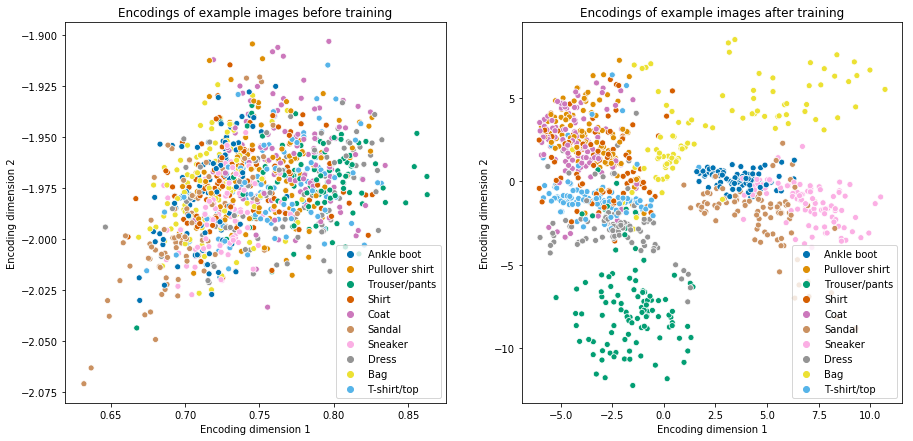

In [22]:
# Compare the example encodings before and after training

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
sns.scatterplot(pretrain_example_encodings[:, 0],
                pretrain_example_encodings[:, 1],
                hue=class_names[example_labels], ax=axs[0],
                palette=sns.color_palette("colorblind", 10));
sns.scatterplot(posttrain_example_encodings[:, 0],
                posttrain_example_encodings[:, 1],
                hue=class_names[example_labels], ax=axs[1],
                palette=sns.color_palette("colorblind", 10));

axs[0].set_title('Encodings of example images before training');
axs[1].set_title('Encodings of example images after training');

for ax in axs: 
    ax.set_xlabel('Encoding dimension 1')
    ax.set_ylabel('Encoding dimension 2')
    ax.legend(loc='lower right')

#note como despues de entrenar forma especies de closter agrupando codificaciones segun su parecido

In [21]:
# Compute the autoencoder's reconstructions

reconstructed_example_images=autoencoder(example_images)

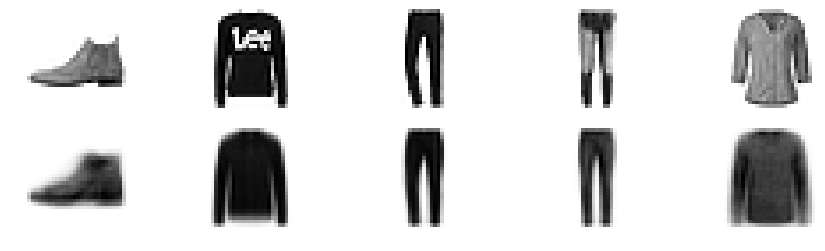

In [23]:
# Evaluate the autoencoder's reconstructions

f, axs = plt.subplots(2, 5, figsize=(15, 4))
for j in range(5):
    axs[0, j].imshow(example_images[j], cmap='binary')
    axs[1, j].imshow(reconstructed_example_images[j].numpy().squeeze(), cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')

***
<a class="anchor" id="tutorial2"></a>
## Minimising Kullback-Leibler divergence

When implementing the $\textbf{Variational Autoencoder}$ algorithm, we want to maximize the objective function $\textbf{ELBO}$ (Evidence Lower Bound), which can be expressed as the sum of two terms:

1. The expected reconstruction loss.

2. The Kullback-Leibler (KL) divergence between the prior and posterior distributions, which measures the discrepancy between the two distributions.

Remember that KL can be written as an expected value, it is negative (you made detailed notes of KL in another notebook).

KL is $0$ if $p=q$ a.e (almost everywhere), i.e., they coincide except for a set of measure $0$ (countable set of points in $\mathbb{R}$) if Lebesgue measure is used $\lambda([a,b])=|b-a|$.

Additionally, KL is not symmetric in the distribution space, i.e.,
 $ D_{KL}\big[q \ || \ p\big] \neq D_{KL}\big[p \ || \ q\big]$

$\begin{equation}
    D_{KL}\big[q \ || \ p\big] =\begin{cases}
                                        \text{E}_{X\sim q}\big[
                                           \log q(X) - \log p(X)\big] &\text{if } p(x) = 0 \implies q(x) = 0,\\
                                        \infty &\text{otherwise.}
                                       \end{cases}
\end{equation}$

In [39]:
#Let's define two distributions p and q
#This bijector is used to form the lower triangular matrix for our distribution
#It takes a vector, in this case of length 3, and produces a 2x2 lower triangular matrix with positive entries on 
#the diagonal. The length of the vector passed (3) corresponds to the number of non-zero elements in the lower 
#triangle of the matrix.

#FillScaleTriL is very useful for initializing randomizing a covariance matrix. A covariance matrix must be
#symmetric and positive definite. This is useful as an initializer when one wants to learn a complete covariance
#matrix of a Gaussian distribution (you made a notebook detailing this process).
#When passing a tensor to FillScaleTriL, the covariance matrix is always valid (it fulfills its definition)
#regardless of the values of the tensor we send.

scale_tril=tfb.FillScaleTriL()([-0.5,1.25,1.])

#Inside, FillScaleTriL does something similar to the following:
#It takes the input vector and arranges them in the lower triangle of a matrix (forming a lower triangular matrix)
#with the given elements. The matrix is filled spirally in the clockwise direction, which is done with FillTriangular.
#It ensures that the diagonal is positive, which is done with the TransformDiagonal bijector, which in turn applies
#a Softplus bijector. This is responsible for mapping the diagonal to positive values because Softplus:IR->IR⁺
#and also applies a small translation with the Shift bijector to ensure that the diagonal is away from 0 and avoids
#numerical problems.

#In code, the above would look like this:

tfb.Chain([
    tfb.TransformDiagonal(tfb.Chain([tfb.Shift(1e-5),tfb.Softplus()])),
    tfb.FillTriangular()
])

#We define p as a 2-dimensional Gaussian distribution with full covariance using
#MultivariateNormalTriL, which receives loc (where the distribution is centered)
#scale_tril lower triangular matrix that comes from the Cholesky decomposition of the full covariance matrix.

p=tfd.MultivariateNormalTriL(loc=0.,scale_tril=scale_tril)

#Let's define the distribution q as an isotropic Gaussian with mean 0.

q=tfd.MultivariateNormalDiag(loc=[0.,0.])

#We can calculate its KL divergence using the provided kl_divergence function in tfd.

tfd.kl_divergence(q,p)

#If you check the documentation, there is a list of all pairs of distributions for which an analytical expression of KL is registered. For two Gaussian distributions, 
#the KL divergence can be calculated analytically.

<tf.Tensor: shape=(), dtype=float32, numpy=3.0560925>

In [47]:
#Let's see an example of how to use KL divergence as an objective function to train a parameterized distribution:

#Let's define distribution p that we want to approximate, i.e., it is the target density we want to reach.

scale_tril=tfb.FillScaleTriL()([-0.5,1.25,1.])
p=tfd.MultivariateNormalTriL(loc=0.,scale_tril=scale_tril)


#q will be the trainable distribution that we want to learn to approximate p.
q=tfd.MultivariateNormalDiag(
    #We make its parameters trainable variables.
    loc=tf.Variable(tf.random.normal([2])),#We make loc a variable initialized randomly
    #transform variable in tfp.util does not allow modifying the variable by applying a bijector 
     #in this case, applying exp since we need this parameter to always be positive.

    scale_diag=tfp.util.TransformedVariable(tf.random.uniform([2]),bijector=tfb.Exp()),#We do the same for the scale.
)

#Let's start by defining the pieces of our training loop:

#Loss calculation and gradients.
@tf.function # autograph to better performance
def loss_and_grads(q_dist):
    with tf.GradientTape() as tape:
        loss=tfd.kl_divergence(q_dist,p)#Remember KL is not symmetric, if here we define tfd.kl_divergence(p, q_dist)
         #we change behavior.
    return loss,tape.gradient(loss,q_dist.trainable_variables)    

#We choose an optimizer to apply to the gradients.

opt=tf.keras.optimizers.Adam()

#We define the training loop in number of steps.
num_train_steps=1
for i in range(num_train_steps):
    loss,grads=loss_and_grads(q)
    opt.apply_gradients(zip(grads,q.trainable_variables))
    
#The distribution q will try to match the distribution as closely as possible.
#In this example, we want to approximate a full covariance Gaussian distribution with
#a diagonal Gaussian, which is impossible to approximate well because the family of parameterized distributions
#q does not contain distribution p (you made a notebook on how to approximate it well).

#This is a very common situation when we want to learn a distribution (we apply the
#principle of variational inference), it depends a lot on the parameterized distribution we choose.

In [94]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

In [50]:
# Define a target distribution, p
tf.random.set_seed(41)

p_mu=[0.,0.]
p_L=tfb.Chain([
    tfb.TransformDiagonal(tfb.Softplus()),
    tfb.FillTriangular()
])(tf.random.uniform([3]))

p=tfd.MultivariateNormalTriL(loc=p_mu,scale_tril=p_L)

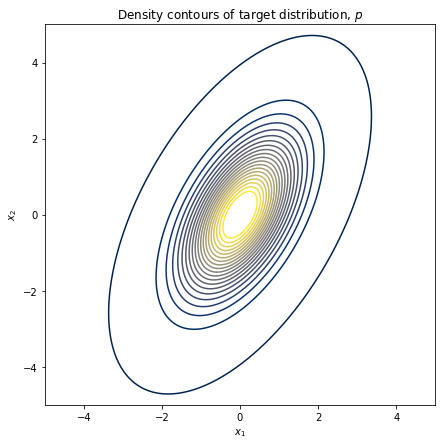

In [51]:
# Plot the target distribution's density contours

def plot_density_contours(density, X1, X2, contour_kwargs, ax=None):
    '''
        Plots the contours of a bivariate TensorFlow density function (i.e. .prob()).
        X1 and X2 are numpy arrays of mesh coordinates.
    '''
    X = np.hstack([X1.flatten()[:, np.newaxis], X2.flatten()[:, np.newaxis]])
    density_values = np.reshape(density(X).numpy(), newshape=X1.shape)
    
    if ax==None:
        _, ax = plt.subplots(figsize=(7, 7))
    
    ax.contour(X1, X2, density_values, **contour_kwargs)
    return(ax)

x1 = np.linspace(-5, 5, 1000)
x2 = np.linspace(-5, 5, 1000)
X1, X2 = np.meshgrid(x1, x2)
f, ax = plt.subplots(1, 1, figsize=(7, 7))

# Density contours are linearly spaced
contour_levels = np.linspace(1e-4, 10**(-0.8), 20) # specific to this seed
ax = plot_density_contours(p.prob, X1, X2, 
                           {'levels':contour_levels, 
                            'cmap':'cividis'}, ax=ax)
ax.set_xlim(-5, 5); ax.set_ylim(-5, 5); 
ax.set_title('Density contours of target distribution, $p$')
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$');

In [54]:
# Initialize an approximating distribution, q, that has diagonal covariance

tf.random.set_seed(41)

q=tfd.MultivariateNormalDiag(
    loc=tf.Variable(tf.random.normal([2])),
    scale_diag=tfp.util.TransformedVariable(tf.random.uniform([2]),bijector=tfb.Exp())
)

In [55]:
# Define a function for the Kullback-Leibler divergence

@tf.function
def loss_and_grads(dist_a,dist_b):
    with tf.GradientTape() as tape:
        loss=tfd.kl_divergence(dist_a,dist_b)
    return loss,tape.gradient(loss,dist_a.trainable_variables) 

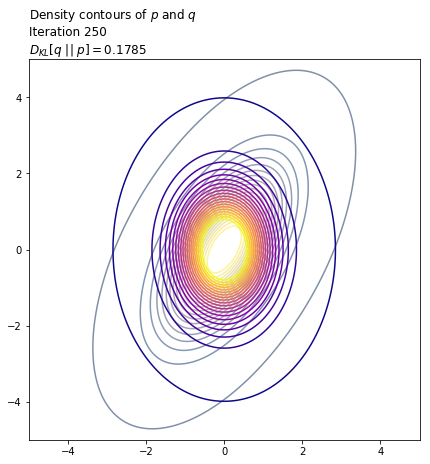

In [56]:
#training loop that computes KL[q || p], updates q's parameters using its gradients

num_train_steps = 250
opt = tf.keras.optimizers.Adam(learning_rate=.01)
for i in range(num_train_steps):
    
    # Compute the KL divergence and its gradients
    q_loss, grads = loss_and_grads(q, p)
    
    # Update the trainable variables using the gradients via the optimizer
    opt.apply_gradients(zip(grads, q.trainable_variables))
    
    # Plot the updated density 
    if ((i + 1) % 10 == 0):
        clear_output(wait=True)
        ax = plot_density_contours(p.prob, X1, X2,
                                   {'levels':contour_levels,
                                    'cmap':'cividis', 'alpha':0.5})
        ax = plot_density_contours(q.prob, X1, X2, 
                                   {'levels':contour_levels,
                                    'cmap':'plasma'}, ax=ax)
        ax.set_title('Density contours of $p$ and $q$\n' +
                     'Iteration ' + str(i + 1) + '\n' +
                      '$D_{KL}[q \ || \ p] = ' + 
                      str(np.round(q_loss.numpy(), 4)) + '$',
                      loc='left')
        plt.pause(.01)
        
#Note how it will never be approximated correctly because one is tilted and the other is not.         

In [57]:
# Re-fit the distribution, this time fitting q_rev by minimising KL[p || q_rev]
tf.random.set_seed(41)

q_rev=tfd.MultivariateNormalDiag(
    loc=tf.Variable(tf.random.normal([2])),
    scale_diag=tfp.util.TransformedVariable(tf.random.uniform([2]),bijector=tfb.Exp())
)


In [58]:
# Edit loss_and_grads function

@tf.function
def loss_and_grads(dist_a,dist_b,reverse=False):
    with tf.GradientTape() as tape:
        if not reverse:
            loss=tfd.kl_divergence(dist_a,dist_b)
        else:
            loss=tfd.kl_divergence(dist_b,dist_a)
    return loss,tape.gradient(loss,dist_a.trainable_variables) 

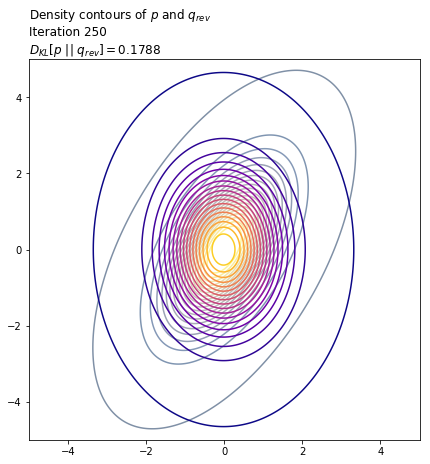

In [59]:
# Re-initialize optimizer, run training loop

opt = tf.keras.optimizers.Adam(learning_rate=.01)
for i in range(num_train_steps):
    # Reverse the KL divergence terms - compute KL[p || q_rev] 
    q_rev_loss, grads = loss_and_grads(q_rev, p, reverse=True)
    
    # Update the trainable variables using the gradients via the optimizer
    opt.apply_gradients(zip(grads, q_rev.trainable_variables))
    
    # Plot the updated density 
    if ((i + 1) % 10 == 0):
        clear_output(wait=True)
        ax = plot_density_contours(p.prob, X1, X2,
                                   {'levels':contour_levels,
                                    'cmap':'cividis', 'alpha':0.5})
        ax = plot_density_contours(q_rev.prob, X1, X2, 
                                   {'levels':contour_levels,
                                    'cmap':'plasma'}, ax=ax)
        ax.set_title('Density contours of $p$ and $q_{rev}$\n' +
                     'Iteration ' + str(i + 1) + '\n' +
                      '$D_{KL}[p \ || \ q_{rev}] = ' + 
                      str(np.round(q_rev_loss.numpy(), 4)) + '$',
                      loc='left')
        plt.pause(.01)

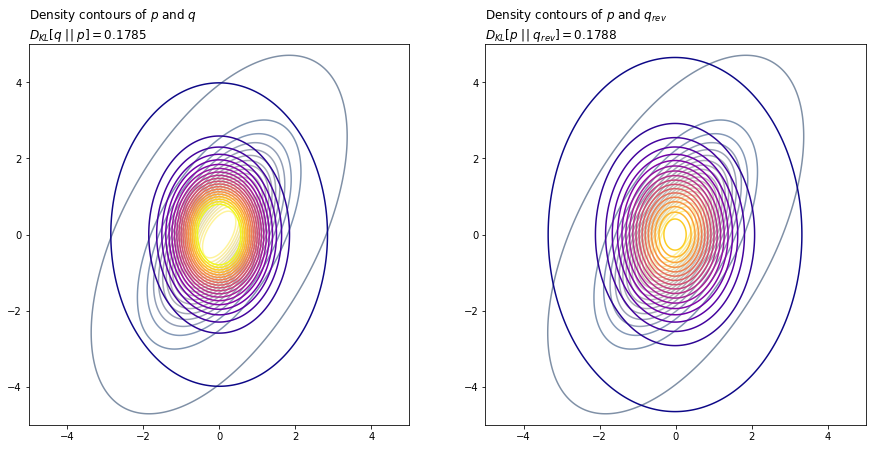

In [60]:
# Plot q and q_rev alongside one another

f, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0] = plot_density_contours(p.prob, X1, X2,
                           {'levels':contour_levels,
                            'cmap':'cividis', 'alpha':0.5}, ax=axs[0])
axs[0] = plot_density_contours(q.prob, X1, X2, 
                           {'levels':contour_levels,
                            'cmap':'plasma'}, ax=axs[0])
axs[0].set_title('Density contours of $p$ and $q$\n' +
              '$D_{KL}[q \ || \ p] = ' + str(np.round(q_loss.numpy(), 4)) + '$',
              loc='left')

axs[1] = plot_density_contours(p.prob, X1, X2,
                           {'levels':contour_levels,
                            'cmap':'cividis', 'alpha':0.5}, ax=axs[1])
axs[1] = plot_density_contours(q_rev.prob, X1, X2, 
                           {'levels':contour_levels,
                            'cmap':'plasma'}, ax=axs[1])
axs[1].set_title('Density contours of $p$ and $q_{rev}$\n' +
              '$D_{KL}[p \ || \ q_{rev}] = ' + str(np.round(q_rev_loss.numpy(), 4)) + '$',
              loc='left');

---
<a class="anchor" id="tutorial3"></a>
## Maximising the ELBO 

Review of terminology:
- $p(z)$ = prior
- $q(z|x)$ = encoding distribution
- $p(x|z)$ = decoding distribution

\begin{align}
\log p(x) &\geq \mathrm{E}_{Z \sim q(z | x)}\big[−\log q(Z | x) + \log p(x, Z)\big]\\
          &= - \mathrm{KL}\big[ \ q(z | x) \ || \ p(z) \ \big] + \mathrm{E}_{Z \sim q(z | x)}\big[\log p(x | Z)\big] 
\end{align}

So far we have seen the components that make up a $\textbf{Variational Autoencoder}$. It is time to put them all together. Remember that if KL is not analytical, neither will ELBO be. In this case, the Monte Carlo approximation exists, you made notes regarding this in the KL notebook.

In general, the $\textbf{Variational Autoencoder}$ assumes that the example data is generated with the following process:

First, a sample is taken from a random variable with respect to a distribution, in this case, an isotropic Gaussian. This $p(z)$ is our prior distribution:
$$z \sim N(0,I) = p(z)$$

This random variable is transformed by a function $f = decoder$ that parameterizes the distribution from which we sample $x$:
$$p(x|z) = decoder(z) \hspace{5mm} x \sim p(x|z)$$

The algorithm requires us to define an $encoder$ (a recognition network), denoted by $q$. This $encoder$ takes a sampled data $x$ as input and returns the distribution over the variable $z$. This distribution is an approximation of the true posterior distribution of our model:
$$encoder(x) = q(z|x) \approx p(z|x)$$

The goal is to maximize the ELBO, which is the lower bound of the logarithm of the evidence of our model:
\begin{align}
\log p(x) &\geq \mathrm{E}_{Z \sim q(z | x)}\big[-\log q(Z | x) + \log p(x, Z)\big] = \\
          &\underbrace{- \mathrm{KL}\big[ \ q(z | x) \ || \ p(z) \ \big]}_\text{negative KL divergence from prior $p(z)$ to the approximate posterior given by the encoder} \\
          &\underbrace{+ \mathrm{E}_{Z \sim q(z | x)}\big[\log p(x | Z)\big]}_\text{Expected Log Likelihood under the approximate posterior distribution of the encoder}
\end{align}

Thus:

In [80]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape,Conv2D,Conv2DTranspose
import matplotlib.pyplot as plt
import numpy as np
tfpl=tfp.layers

#Let's implement our encoder network.

#We assume z is two-dimensional.
latent_size=2
#We assume that the data is binary-valued.
event_shape=(28,28,1)

encoder=Sequential([
    Conv2D(8,(5,5),strides=2,activation='tanh',input_shape=event_shape),
    Conv2D(8,(5,5),strides=2,activation='tanh'),
    Flatten(),
    Dense(64,activation='tanh'),
    Dense(2*latent_size),
    #We use the dense layer to parameterize our approximate posterior distribution.
    #This last layer returns the MultivariateNormalDiag distribution as the approximate posterior.
    tfpl.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(
    #Its parameters are passed the outputs of the dense layer (we parameterize it)
    #and it is trainable.
        loc=t[...,:latent_size],scale_diag=tf.math.exp(t[...,latent_size:])
    ))
],name='encoder')

#Let's see what this encoder does if we pass it a batch of 16 data points:
encoder(x_train[:16]) #This will cause an error because x_train does not exist.
#encoder returns MultivariateNormalDiag with batch_shape=[16] event_shape=[2]
#i.e., a batch of 16 Gaussians of 2 variables.

#Let's define the decoder network.

#It receives a vector of length 2.

decoder=Sequential([
    Dense(64,activation='tanh',input_shape=(latent_size,)),
    Dense(128,activation='tanh'),
    Reshape((4,4,8)),
    Conv2DTranspose(8,(5,5),strides=2,output_padding=1,activation='tanh'),
    Conv2DTranspose(8,(5,5),strides=2,output_padding=1,activation='tanh'),
    Conv2D(1,(3,3),padding='SAME'),
    Flatten(),
    #After flattening the matrix, each element in the resulting vector is used to parameterize
    #independent distributions with the same event_shape as the data.
    tfpl.IndependentBernoulli(event_shape)
],name='decoder')

#Let's see what this decoder does if we pass it a batch of 16 vectors of length 2 initialized randomly:
decoder(tf.random.normal([16,latent_size]))
#It returns an IndependentBernoulli with batch_shape=[16], event_shape=[28,28,1], i.e., a batch of
#independent Bernoullis with event_shape equal to that of the data.



#We have defined our decoder and encoder. Now we need to define our base distribution (prior).
#Let's define it as an isotropic Gaussian N(0,I).
prior=tfd.MultivariateNormalDiag(loc=tf.zeros(latent_size)) #batch_shape=[] , event_shape=[2]

#Let's define a loss function that receives:
#x_true: batch of data examples
#approx_posterior: output of encoder (MultivariateNormalDiag)
#x_pred: output of the decoder (IndependentBernoulli)
#prior_dist: the assumed distribution of the data
def loss_fn(x_true,approx_posterior,x_pred,prior_dist):
    return tf.reduce_mean(tfd.kl_divergence(approx_posterior,prior_dist)-x_pred.log_prob(x_true))
    #It returns the mean of the ELBO=loss_fn over the batch.


#If we want to maximize ELBO, we need to minimize the loss function because we are multiplying by -1 * ELBO.
#Remember max(f(x)) = min(-f(x)).

#We can also calculate the KL divergence using Monte Carlo approximation instead of analytically.
def loss_fn(x_true,approx_posterior,x_pred,prior_dist):
    #Likelihood term of the ELBO function 
    reconstruction_loss=-x_pred.log_prob(x_true)
    #Monte Carlo approximation of KL using only 1 sample from the posterior
    #You can use more than 1 sample.
    approx_posterior_sample=approx_posterior.sample()
    kll_aprox=(approx_posterior.log_prob(approx_posterior_sample)-
              prior_dist.log_prob(approx_posterior_sample))
    return tf.reduce_mean(kl_approx-reconstruction_loss)

#We define a function to calculate loss and gradients.
@tf.function # autograph to better performance
def get_loss_and_grads(x):
    with tf.GradientTape() as tape:
        approx_posterior=encoder(x)
        approx_posterior_sample=approx_posterior.sample()
        x_pred=decoder(approx_posterior_sample)
        current_loss=loss_fn(x,approx_posterior,x_pred,prior)
        grads=tape.gradient(current_loss,encoder.trainable_variables+decoder.trainable_variables)
    return current_loss,grads 

#We choose an optimizer.
opt=tf.keras.optimizers.Adam() #This will cause an error because train_data does not exist.
num_epochs=1
#Training loop.
for epoch in range(num_epochs):
    for train_batch in train_data:
        loss,grads=get_loss_and_grads(train_batch)
        opt.apply_gradients(zip(grads,encoder.trainable_variables+decoder.trainable_variables))
        
#We have implemented a Variational Autoencoder from start to finish. We have an easy-to-implement generative model.
 
z=prior.sample(1)
x=decoder(z).sample()

#We can use the encoder to encode a batch of data samples.
x_encoded=encoder(x_sample)#output distributions 

#The above process can be fully resumed by defining the Variational Autoencoder (VAE) algorithm as:
def vae(inputs):
    approx_posterior=encoder(inputs)
    decoded=decoder(approx_posterior.sample())
    return decoded.sample()

#finali
reconstructed=vae(x_sample)

In [131]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape
import matplotlib.pyplot as plt
import numpy as np

In [132]:
# Import Fasion MNIST, make it a TensorFlow Dataset

(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.
example_x = x_test[:16]

batch_size = 64
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)

In [133]:
# Define the encoding distribution, q(z|x)
latent_size=2
event_shape=(28,28)

encoder=Sequential([
    Flatten(input_shape=event_shape),
    Dense(256,activation='relu'),
    Dense(128,activation='relu'),
    Dense(64,activation='relu'),
    Dense(32,activation='relu'),
    Dense(2*latent_size),
    tfpl.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(
        loc=t[...,:latent_size],scale_diag=tf.math.exp(t[...,latent_size:])
    ))
],name='encoder')

In [134]:
# Pass an example image through the network - should return a batch of MultivariateNormalDiags.

encoder(example_x)

<tfp.distributions.MultivariateNormalDiag 'encoder_distribution_lambda_14_MultivariateNormalDiag' batch_shape=[16] event_shape=[2] dtype=float32>

In [135]:
# Define the decoding distribution, p(x|z)
decoder=Sequential([
    Dense(32,activation='relu'),
    Dense(64,activation='relu'),
    Dense(128,activation='relu'),
    Dense(256,activation='relu'),
    Dense(tfpl.IndependentBernoulli.params_size(event_shape)),
    tfpl.IndependentBernoulli(event_shape)
    
])


In [136]:
# Pass a batch of examples to the decoder

decoder(tf.random.normal([16,latent_size]))

<tfp.distributions.Independent 'sequential_7_independent_bernoulli_12_IndependentBernoulli_Independentsequential_7_independent_bernoulli_12_IndependentBernoulli_Bernoulli' batch_shape=[16] event_shape=[28, 28] dtype=float32>

In [137]:
# Define the prior, p(z) - a standard bivariate Gaussian

prior=tfd.MultivariateNormalDiag(loc=tf.zeros(latent_size))

The loss function we need to estimate is

\begin{equation}
-\mathrm{ELBO} = \mathrm{KL}[ \ q(z|x) \ || \ p(z) \ ] - \mathrm{E}_{Z \sim q(z|x)}[\log p(x|Z)]\\
\end{equation}

where $x = (x_1, x_2, \ldots, x_n)$ refers to all observations, $z = (z_1, z_2, \ldots, z_n)$ refers to corresponding latent variables.

Assumed independence of examples implies that we can write this as

\begin{equation}
\sum_j \mathrm{KL}[ \ q(z_j|x_j) \ || \ p(z_j) \ ] - \mathrm{E}_{Z_j \sim q(z_j|x_j)}[\log p(x_j|Z_j)]
\end{equation}

In [138]:
# Specify the loss function, an estimate of the -ELBO

def loss(x,encoding_dist,sampled_decoding_dist,prior):
    return tf.reduce_sum(
        tfd.kl_divergence(encoding_dist,prior)-sampled_decoding_dist.log_prob(x)
    )

In [139]:
# Define a function that returns the loss and its gradients
@tf.function # autograph para mejorar rendimiento
def get_loss_and_grads(x):
    with tf.GradientTape() as tape:
        encoding_dist=encoder(x)
        sampled_z=encoding_dist.sample()
        sampled_decoding_dist=decoder(sampled_z)
        current_loss=loss(x,encoding_dist,sampled_decoding_dist,prior)
    grads=tape.gradient(current_loss,encoder.trainable_variables+decoder.trainable_variables)
    return current_loss,grads 


In [140]:
# Compile and train the model

num_epochs = 5
opt = tf.keras.optimizers.Adam()
for i in range(num_epochs):
    for train_batch in x_train:
        current_loss, grads = get_loss_and_grads(train_batch)
        opt.apply_gradients(zip(grads, encoder.trainable_variables
                                       + decoder.trainable_variables))
        
    print('-ELBO after epoch {}: {:.0f}'.format(i+1, current_loss.numpy()))

-ELBO after epoch 1: 9087
-ELBO after epoch 2: 8874
-ELBO after epoch 3: 8887
-ELBO after epoch 4: 8767
-ELBO after epoch 5: 8728


In [141]:
# Connect encoder and decoder, compute a reconstruction
def vae(inputs):
    approx_posterior=encoder(inputs)
    decoding_dist=decoder(approx_posterior.sample())
    return decoding_dist.sample()

example_reconstruction=vae(example_x)

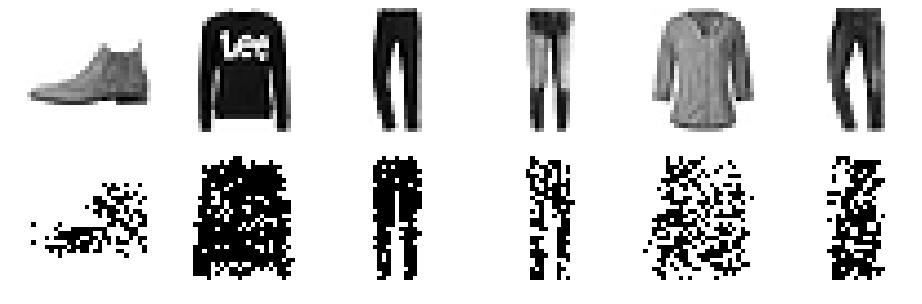

In [142]:
# Plot examples against reconstructions

f, axs = plt.subplots(2, 6, figsize=(16, 5))

for j in range(6):
    axs[0, j].imshow(example_x[j, :, :].squeeze(), cmap='binary')
    axs[1, j].imshow(example_reconstruction[j, :, :], cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')

In [143]:
# Generate an example - sample a z value, then sample a reconstruction from p(x|z)

z=prior.sample(6)
generated_x=decoder(z).mean()

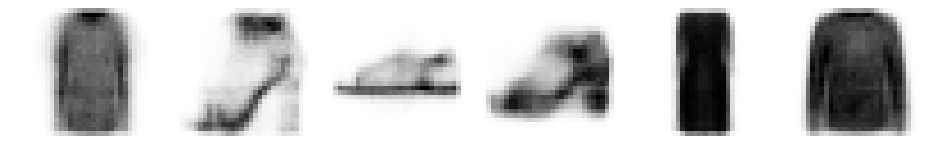

In [144]:
# Display generated_x

f, axs = plt.subplots(1, 6, figsize=(16, 5))
for j in range(6):
    axs[j].imshow(generated_x[j, :, :].numpy().squeeze(), cmap='binary')
    axs[j].axis('off')

In [130]:
# -ELBO estimate using an estimate of the KL divergence

def loss(x, encoding_dist, sampled_decoding_dist,
         prior, sampled_z):
    recon_loss = -sampled_decoding_dist.log_prob(x)
    kl_approx = (encoding_dist.log_prob(sampled_z)
                    - prior.log_prob(sampled_z))
    return tf.reduce_sum(kl_approx + recon_loss)

***
<a class="anchor" id="tutorial4"></a>
# KL divergence layers
Are layers available in the TensorFlow Probability layer module tfpl. Let's see how they work.

In [ ]:
#We define our prior distribution (base).

#It is a diagonal Gaussian distribution of 4 dimensions with identity covariance matrix.
latent_size=4
prior=tfd.MUltivariateNormalDiag(loc=tf.zeros(latent_size))

#We define the encoder.
encoder = Sequential([
    # Dense unit of 64 units takes 1-dimensional data of length 12
    Dense(64, activation='relu', input_shape=(12,)),
    # The next layer outputs the parameters of the approximation of the posterior distribution
    # Note that it doesn't have an activation function
    Dense(tfpl.MultivariateNormalTriL.params_size(latent_size)),
    # We have the approximation of the posterior distribution
    tfpl.MultivariateNormalTriL(latent_size),
    # Finally, we have the KLDivergenceAddLoss layer. This layer doesn't change its inputs in any way
    # It can be understood as a pass-through layer requiring input from the posterior distribution given by the previous layer
    # This layer adds the KL divergence to the model so it automatically becomes part of the loss function
    # to be optimized later, when using .compile and .fit. This is similar to when we add weight decay
    # to the model using kernel_regularizer in a dense or convolutional layer. This way, we only need to worry about
    # defining the reconstruction loss function
    tfpl.KLDivergenceAddLoss(prior)
])

# It outputs a 12-dimensional independent normal distribution
decoder = Sequential([
    Dense(64, activation='relu', input_shape=(latent_size,)),
    Dense(tfpl.IndependentNormal.param_size(12)),
    tfpl.IndependentNormal(12)
])

# Let's define the variational autoencoder
vae = Model(inputs=encoder.input, outputs=decoder(encoder.output))

# Let's define the loss function; we no longer need the KL divergence
# We only define the part related to the reconstruction loss
def loss_fn(x_true, x_pred):
    return -x_pred.log_prob(x_true)
# When compiling, we pass this because the KL divergence is automatically added by the layer
vae.compile(loss=loss_fn)
# We train where train_data is a data set object of pairs (x_train, x_train) because we need it in this format for vae
vae.train(train_data, epochs=20)

# Now tfpl.KLDivergenceAddLoss has other parameters
tfpl.KLDivergenceAddLoss(prior,  # prior distribution (base)
                         weight=10,  # factor by which the KL value is scaled before adding it to the reconstruction loss,
                         # default is None, so it multiplies by 1, if we give it a large value in the loss function,
                         # KL is given more importance
                         use_exact_kl=True,  # whether to use the analytical form, False by default (Monte Carlo)
                         test_points_fn=lambda q: q.sample(10),  # by changing this property we can change, for example,
                         # the number of points used for Monte Carlo, only used when using this approximation
                         # i.e., when use_exact_kl=False
                         test_points_reduce_axis=0  # indicates which dimension of the KL estimation tensor should
                         # be reduced when passing more than one point to calculate Monte Carlo (reduction
                         # is done by taking average), in this case we have a vector that is calculated using 10 points
                         # the approxkl vector has the shape (number of points, batch) as the reduction is in the
                         # 0th dimension the tensor is reduced to a scalar averaging over the sample axis and summing
                         # over the batch axis, if you define it as None all dimensions are averaged and if you define
                         # it as an empty tuple () then all dimensions are summed
                        )

# Note: as Monte Carlo is calculated by:
# approx_posterior.log_prob(approx_posterior_sample) - prior.log_prob(approx_posterior_sample)
# the KLDivergenceAddLoss layer extracts a tensor from the previous layer i.e., (tfpl.MultivariateNormalTriL(latent_size))
# using the function defined in convert_to_tensor_fn, note
# that in this layer none is defined but by default it has set
# convert_to_tensor_fn=tfp.Distribution.sample which is correct as for calculating Monte Carlo we need
# approx_posterior_sample if we change the convert_to_tensor_fn option to for example
# convert_to_tensor_fn=tfp.Distribution.mean we also have to change the Monte Carlo calculation to
# approx_posterior.log_prob(approx_posterior_mean) - prior.log_prob(approx_posterior_mean)

In [ ]:
# We can implement another alternative layer that does the same as KLDivergenceAddLoss
# The KLDivergenceRegularizer layer

# Let's define the encoder
encoder = Sequential([
    Dense(64, activation='relu', input_shape=(12,)),
    Dense(tfpl.MultivariateNormalTriL.params_size(latent_size)),
    # It fulfills the same function, the parameters mean the same but instead of defining it as
    # a layer in the model, we pass it in the final layer through the activity_regularizer argument
    tfpl.MultivariateNormalTriL(latent_size, 
                               activity_regularizer=tfpl.KLDivergenceRegularizer(
                                   prior,
                                   weight=10,
                                   use_exact_kl=False,
                                   test_points_fn=lambda q: q.sample(10),
                                   test_points_reduce_axis=0
                               ))
])


In [150]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape
import matplotlib.pyplot as plt
import numpy as np

In [151]:
# Import Fashion MNIST

(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32')/256. + 0.5/256
x_test = x_test.astype('float32')/256. + 0.5/256
example_x = x_test[:16]

batch_size = 32
x_train = tf.data.Dataset.from_tensor_slices((x_train, x_train)).batch(batch_size)
x_test = tf.data.Dataset.from_tensor_slices((x_test, x_test)).batch(batch_size)

In [152]:
# Define latent_size and the prior, p(z)
latent_size=4
#covariance matrix is the identity for this distribution
prior=tfd.MultivariateNormalDiag(loc=tf.zeros(latent_size))

In [153]:
# Define the encoding distribution using a tfpl.KLDivergenceAddLoss layer
event_shape=(28,28)

encoder=Sequential([
    Flatten(input_shape=event_shape),
    Dense(128,activation='relu'),
    Dense(64,activation='relu'),
    Dense(32,activation='relu'),
    Dense(16,activation='relu'),
    Dense(tfpl.MultivariateNormalTriL.params_size(latent_size)),
    tfpl.MultivariateNormalTriL(latent_size),
    tfpl.KLDivergenceAddLoss(prior)
],name='encoder')


In [154]:
# See how KLDivergenceAddLoss affects encoder.losses
# encoder.losses before the network has received any inputs
encoder.losses
#no hay kl 

[<tf.Tensor 'kl_divergence_add_loss/kldivergence_loss/batch_total_kl_divergence:0' shape=() dtype=float32>]

In [155]:
# Pass a batch of images through the encoder

encoder(example_x)

<tfp.distributions.MultivariateNormalTriL 'encoder_multivariate_normal_tri_l_MultivariateNormalTriL_MultivariateNormalTriL' batch_shape=[16] event_shape=[4] dtype=float32>

In [156]:
# See how encoder.losses has changed

encoder.losses
#ya calculo kl

[<tf.Tensor: shape=(), dtype=float32, numpy=0.59541094>]

In [158]:
# Re-specify the encoder using weight and test_points_fn

encoder=Sequential([
    Flatten(input_shape=event_shape),
    Dense(128,activation='relu'),
    Dense(64,activation='relu'),
    Dense(32,activation='relu'),
    Dense(16,activation='relu'),
    Dense(tfpl.MultivariateNormalTriL.params_size(latent_size)),
    tfpl.MultivariateNormalTriL(latent_size),
    tfpl.KLDivergenceAddLoss(prior,
                            use_exact_kl=False,
                             weight=1.5,
                             test_points_fn=lambda q:q.sample(10),
                             test_points_reduce_axis=0
                            )
],name='encoder')


In [159]:
# Replacing KLDivergenceAddLoss  with KLDivergenceRegularizer in the previous (probabilistic) layer

divergence_regularizer=tfpl.KLDivergenceRegularizer(prior,
                            use_exact_kl=False,
                             weight=1.5,
                             test_points_fn=lambda q:q.sample(5),
                             test_points_reduce_axis=0)

encoder=Sequential([
    Flatten(input_shape=event_shape),
    Dense(128,activation='relu'),
    Dense(64,activation='relu'),
    Dense(32,activation='relu'),
    Dense(16,activation='relu'),
    Dense(tfpl.MultivariateNormalTriL.params_size(latent_size)),
    tfpl.MultivariateNormalTriL(latent_size,activity_regularizer=divergence_regularizer)
],name='encoder')

In [160]:
# Specify the decoder, p(x|z)

decoder = Sequential([
    Dense(16, activation='sigmoid', input_shape=(latent_size,)),
    Dense(32, activation='sigmoid'),
    Dense(64, activation='sigmoid'),
    Dense(2*event_shape[0]*event_shape[1], activation='exponential'),
    Reshape((event_shape[0], event_shape[1], 2)),
    tfpl.DistributionLambda(
        lambda t: tfd.Independent(
            tfd.Beta(concentration1=t[..., 0],
                     concentration0=t[..., 1])
        )
    )
])

In [161]:
# Connect the encoder and decoder to form the VAE
vae=Model(inputs=encoder.inputs,outputs=decoder(encoder.outputs))

In [162]:
# Define a loss that only estimates the expected reconstruction error,
# -E_{Z ~ q(z|x)}[log p(x|Z)]

def log_loss(x_true,x_pred):
    return -tf.reduce_sum(x_pred.log_prob(x_true))


In [164]:
# Compile and fit the model
vae.compile(loss=log_loss)

vae.fit(x_train,validation_data=x_test,epochs=10)

Train for 1875 steps, validate for 313 steps
Epoch 1/10
1875/1875 [==============================] - 106s 57ms/step - loss: -45555.7639 - val_loss: -50802.1625
Epoch 2/10
1875/1875 [==============================] - 100s 53ms/step - loss: -53332.8370 - val_loss: -54654.8253
Epoch 3/10
1875/1875 [==============================] - 100s 54ms/step - loss: -56531.6577 - val_loss: -56605.7201
Epoch 4/10
1875/1875 [==============================] - 100s 53ms/step - loss: -59965.0204 - val_loss: -60502.3834
Epoch 5/10
1875/1875 [==============================] - 100s 53ms/step - loss: -63309.9197 - val_loss: -63406.4645
Epoch 6/10
1875/1875 [==============================] - 100s 53ms/step - loss: -65418.9033 - val_loss: -66223.7298
Epoch 7/10
1875/1875 [==============================] - 99s 53ms/step - loss: -66705.4883 - val_loss: -66834.5326
Epoch 8/10
1875/1875 [==============================] - 101s 54ms/step - loss: -65443.6473 - val_loss: -68121.5323
Epoch 9/10
1875/1875 [==============

In [165]:
# Generate an example reconstruction
example_reconstruction=vae(example_x).mean().numpy().squeeze()

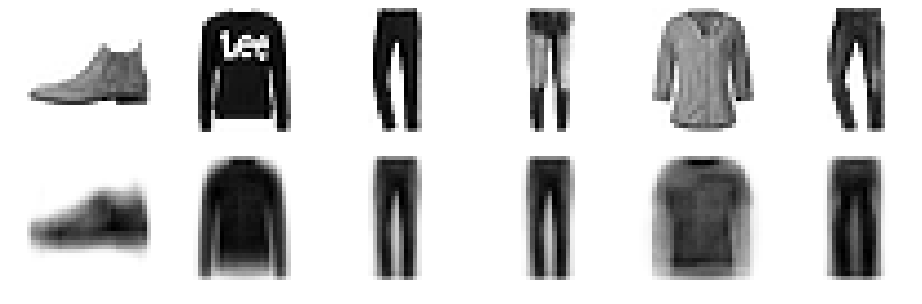

In [166]:
# Plot the example reconstructions

f, axs = plt.subplots(2, 6, figsize=(16, 5))

for j in range(6):
    axs[0, j].imshow(example_x[j, :, :].squeeze(), cmap='binary')
    axs[1, j].imshow(example_reconstruction[j, :, :], cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')